In [1]:
%%capture
!pip install tensorflow pandas tqdm pyyaml h5py

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

In [4]:
data = dict(np.load("./data/data_single_train.npz"))

In [5]:
L = tf.keras.layers

In [6]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [7]:
def R2(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

In [8]:
hparams = {
    "sequence_units": [64, 128],
    "structure_units": [8, 16, 32],
    "concat_dense": [32, 64],
}
hparams = {
    key: hp.HParam(key, hp.Discrete(value))
    for key, value in hparams.items()
}
metrics = [
    hp.Metric("mae", display_name="MAE"),
    hp.Metric("mse", display_name="MSE"),
    hp.Metric("r2", display_name="R2"),
]
hp.hparams_config(
    hparams=list(hparams.values()),
    metrics=metrics
)

<tf.Tensor: shape=(), dtype=bool, numpy=False>

In [9]:
from itertools import product
from random import shuffle

def hparams_combinations(hparams):
    hparams_values = product(*[
        h.domain.values
        for h in hparams.values()
    ])
    hparams = [
        dict(zip(hparams.keys(), values))
        for values in hparams_values
    ]
    shuffle(hparams)
    return hparams

In [10]:
def build_model(hparams):
    sequence_units = hparams["sequence_units"]
    structure_units = hparams["structure_units"]
    concat_dense = hparams["concat_dense"]
    
    input_sequence_feat = L.Input(shape=data["sequence_feat"].shape[1:], name="sequence_feat")
    lstms_sequence_feat = L.LSTM(sequence_units)(input_sequence_feat)
    
    input_sequence_freq = L.Input(shape=data["sequence_freq"].shape[1:], name="sequence_freq")
    dense_sequence_freq = L.Dense(sequence_units, activation="relu")(input_sequence_freq)
    
    input_structure_feat = L.Input(shape=data["structure_feat"].shape[1:], name="structure_feat")
    lstms_structure_feat = L.LSTM(structure_units)(input_structure_feat)
    
    input_structure_freq = L.Input(shape=data["structure_freq"].shape[1:], name="structure_freq")
    dense_structure_freq = L.Dense(structure_units, activation="relu")(input_structure_freq)
    
    concat = L.concatenate([
        lstms_sequence_feat,
        dense_sequence_freq,
        lstms_structure_feat,
        dense_structure_freq
    ])
    
    out_dense0 = L.Dense(concat_dense)(concat)
    out_dense1 = L.Dense(1)(out_dense0)
    
    model = tf.keras.Model(
        inputs=[
            input_sequence_feat,
            input_sequence_freq,
            input_structure_feat,
            input_structure_freq
        ],
        outputs=[out_dense1]
    )
    model.compile(optimizer="adam", loss=rmse, metrics=["mae", "mse", R2])
    return model

In [11]:
model = build_model({"sequence_units": 32, "structure_units": 16, "concat_dense": 32})

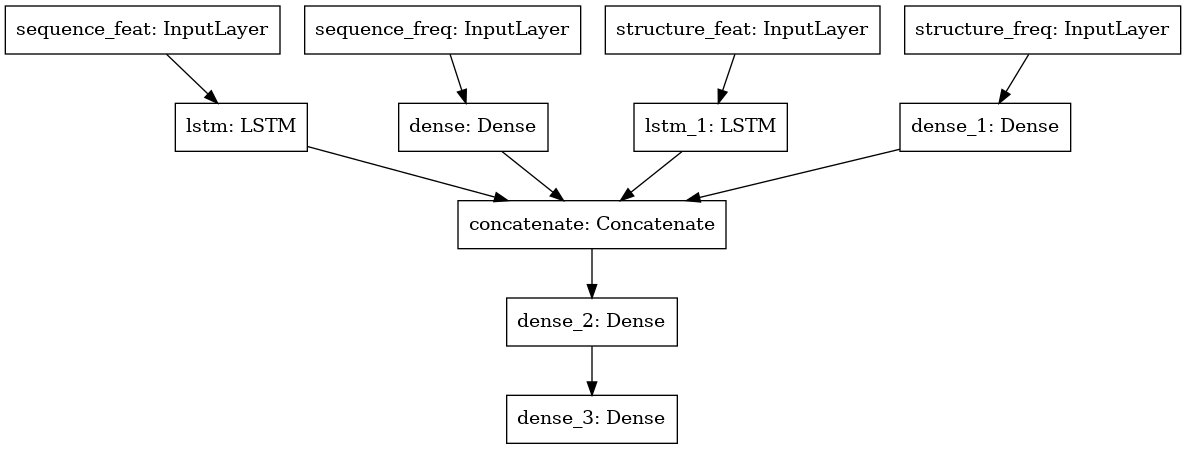

In [12]:
from IPython.display import Image
tf.keras.utils.plot_model(model, to_file="model.png")
Image("model.png")

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_feat (InputLayer)      [(None, 43, 23)]     0                                            
__________________________________________________________________________________________________
sequence_freq (InputLayer)      [(None, 19)]         0                                            
__________________________________________________________________________________________________
structure_feat (InputLayer)     [(None, 43, 3)]      0                                            
__________________________________________________________________________________________________
structure_freq (InputLayer)     [(None, 14)]         0                                            
______________________________________________________________________________________________

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=20)

In [15]:
index = np.arange(len(data["score"]))
train_index, test_index = train_test_split(index, test_size=0.30, random_state=42)
train_index, val_index = train_test_split(train_index, test_size=0.10, random_state=42)
X_train = [data[i.name][train_index] for i in model.inputs]
X_test = [data[i.name][test_index] for i in model.inputs]
X_val = [data[i.name][val_index] for i in model.inputs]
y_train, y_test, y_val = data["score"][train_index], data["score"][test_index],  data["score"][val_index]

In [ ]:
path = "./board"
for i, h in enumerate(tqdm(hparams_combinations(hparams))):
    logs = os.path.join(path, f"run-{i}")
    os.makedirs(logs)
    with tf.summary.create_file_writer(logs).as_default():
        hp.hparams(h)
        model = build_model(h)
        model.fit(
            X_train,
            y_train,
            epochs=int(1e3),
            batch_size=32,
            shuffle=True,
            validation_data=(X_val, y_val),
            callbacks=[early_stop],
            verbose=0
        )
        loss, mae, mse, r2 = model.evaluate(X_test, y_test, verbose=0)
        tf.summary.scalar("loss", loss, step=i)
        tf.summary.scalar("mae", mae, step=i)
        tf.summary.scalar("mse", mse, step=i)
        tf.summary.scalar("r2", r2, step=i)

 42%|████▏     | 5/12 [15:28<20:49, 178.43s/it]

In [ ]:
parameters = {"sequence_units": 64, "structure_units": 16}

In [ ]:
model = build_model(parameters)
X_train = [data[i.name] for i in model.inputs]
y_train = data["score"]
history = model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

In [ ]:
model.save("model.h5")

In [ ]:
_ = pd.DataFrame(history.history).plot(subplots=True, figsize=(10, 8))

In [ ]:
test = dict(np.load("./data/data_single_test.npz"))
X_test = [test[i.name] for i in model.inputs]
y_test = test["score"]
evaluate = pd.DataFrame([y_test, model.predict(X_test).squeeze()], index=["target", "predicted"]).T
evaluate.corr()

In [ ]:
_ = evaluate.plot.scatter("target", "predicted")

In [ ]:
data = dict(np.load("./data/data_multi_train.npz"))

In [ ]:
model = build_model(parameters)
X_train = [data[i.name] for i in model.inputs]
y_train = data["score"]
history = model.fit(
    X_train,
    y_train,
    epochs=200,
    batch_size=64,
    shuffle=True,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

In [ ]:
test = dict(np.load("./data/data_multi_test.npz"))
X_test = [test[i.name] for i in model.inputs]
y_test = test["score"]
evaluate = pd.DataFrame([y_test, model.predict(X_test).squeeze()], index=["target", "predicted"]).T
evaluate.corr()

In [ ]:
_ = evaluate.plot.scatter("target", "predicted")